# Выбор локации для скважины

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

#### Ход исследования

- исследуем и подготовим предоставленные данные
- разобьем данные на тренировочную и тестовую выборки
- создадим, обучим модель (pipeline)
- расчет прибыли и рисков (bootstrap)



#### Итоговый вывод:

Проведено исследование данных с целью определения региона с возможностью получения максимальной прибыли и при этом с вероятностью получить убыток менее 2,5%

Данные получены подготовленные с минимальными выбросами и нормализованными.
В шифровании ID скважины обнаружены повторы возникшие из-за способа кодирования.
Во втором регионе обнаружена сильная корреляция между параметром `f2` и  `product`, необходимо проверить достоверность полученной информации.

При построении графиков в трех проекциях точечной диаграммы, можно заметить что распределения данных по форме сильно отличаются друг от друга . Это возможно из-за того что для каждого региона выбраны разные параметры зашифрованные под одними именами. Для корректного сравнения разных регионах желательно использовать одинаковые параметры если это возможно.

Для предсказания объемов добычи нами была использована модель линейная регрессия(по условию задачи) как демонстрирующая наиболее предсказуемые результаты. Но учитывая показанную точность для регионов №1 и №3, возможно стоит рассмотреть варианты использования других моделей машинного обучения которые справляются не только с линейными зависимостями.

Для безубыточной добычи в пределах бюджета средний запас нефти в одной скважине должен составлять не менее 111,11.
Максимально близкое значение предсказанных запасов показал регион №3 94.7

Но по результатам оценки методом bootstrap лучший результат с учетом риска получения убытка менее 2,5% показал только регион №2.

На основании полученных результатов рекомендуется выбрать регион №2 (`geo_data_1`).

Данные геологоразведки трёх регионов находятся в файлах:
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
from IPython.display import display
import os # Для выбора пути к дф

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
import seaborn as sns

from sklearn.linear_model import LinearRegression # алгоритм классификации - Линейная регрессия
from sklearn.metrics import mean_squared_error # Метрики качеств - MSE
from sklearn.metrics import r2_score # R2
from sklearn.model_selection import train_test_split # Разбиение по выборкам
from sklearn.pipeline import make_pipeline # Создание трубопровода
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # Масштабирование признаков

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



import pandas_profiling
from pandas_profiling import ProfileReport

Загрузим исходные данные

In [2]:
pth1 = '/content/drive/MyDrive/data/geo_data_0.csv'
pth2 = '/content/drive/MyDrive/data/geo_data_1.csv'
pth3 = '/content/drive/MyDrive/data/geo_data_2.csv'
pth4 = 'geo_data_0.csv'
pth5 = 'geo_data_1.csv'
pth6 = 'geo_data_2.csv'

if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
    geo_data_0 = pd.read_csv(pth1)
    geo_data_1 = pd.read_csv(pth2)
    geo_data_2 = pd.read_csv(pth3)
    print("Датасет успешно загружен с локального диска")
elif os.path.exists(pth4) and os.path.exists(pth5) and os.path.exists(pth6):
    geo_data_0 = pd.read_csv(pth4)
    geo_data_1 = pd.read_csv(pth5)
    geo_data_2 = pd.read_csv(pth6)
    print("Датасет успешно загружен с ЯндексПрактикум")
else:
    print("Проверьте правильность пути к датасету")

geo_data = [geo_data_0, geo_data_1, geo_data_2]

Датасет успешно загружен с ЯндексПрактикум


С помощью библиотеки `pandas_profiling` исследуем исходные данные

### Первый регион

In [3]:
def eda_info(data):
    '''
    
    '''

    data.info()
    print('*'*60)

    display(data.describe())
    print('*'*60)

    full_dupl = data.duplicated().sum()
    print(f'В датафрейме {full_dupl} полных дубликатов')
    print('*'*60)

    print('Дубликаты по столбцу ID')
    dupl = pd.DataFrame()
    for i in data[data.id.duplicated()]['id']:
        dupl = dupl.append(data.query('id== @i'), ignore_index=True)
    display(dupl)
    print('*'*60)

    fig = px.scatter_3d(data.sample(n=1000), 
                    x='f0', 
                    y='f1', 
                    z='f2', 
                    color='product')

    fig.update_layout(width=500, height=500)
    fig.show('png')
    print('*'*60)

    data.hist(
        bins=100, 
        figsize=(12, 12), 
        edgecolor = "black"
        )
    plt.show()


    plt.figure(figsize = (12,8))
    sns.heatmap(
        data.corr(), 
        annot=True, 
        vmin=-1, 
        vmax=1, 
        center= 0, 
        cmap= 'coolwarm', 
        square=True
        )
    print('*'*60)
    

    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
************************************************************


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


************************************************************
В датафрейме 0 полных дубликатов
************************************************************
Дубликаты по столбцу ID


,id,f0,f1,f2,product
0,HZww2,0.755284,0.368511,1.863211,30.681774
1,HZww2,1.061194,-0.373969,10.430210,158.828695
2,bxg6G,0.411645,0.856830,-3.653440,73.604260
3,bxg6G,-0.823752,0.546319,3.630479,93.007798
4,A5aEY,-0.039949,0.156872,0.209861,89.249364
5,A5aEY,-0.180335,0.935548,-2.094773,33.020205
6,QcMuo,0.506563,-0.323775,-2.215583,75.496502
7,QcMuo,0.635635,-0.473422,0.862670,64.578675
8,74z30,0.741456,0.459229,5.153109,140.771492
9,74z30,1.084962,-0.312358,6.990771,127.643327


************************************************************


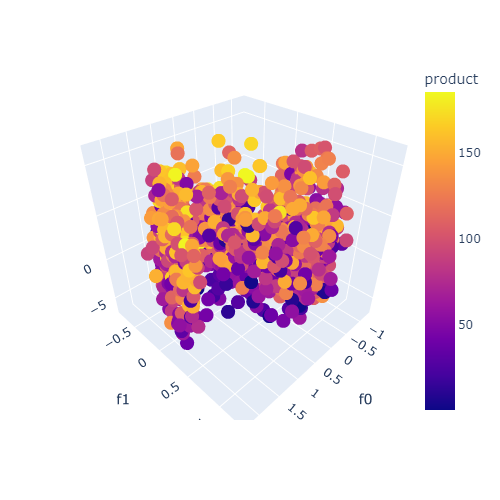

************************************************************


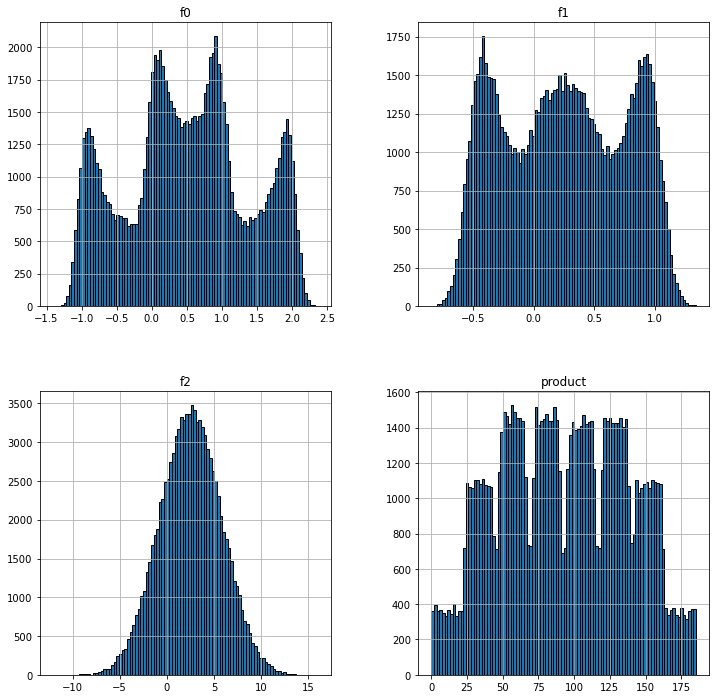

************************************************************


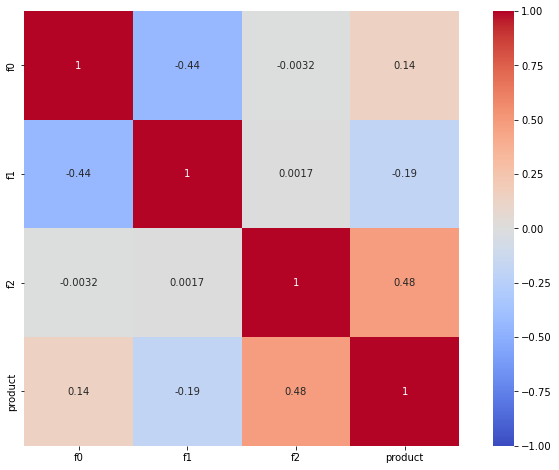

In [4]:
eda_info(geo_data_0)

In [5]:
profile = ProfileReport(geo_data_0, title='geo_data_0', progress_bar=False)
profile.to_file("geo_data_0.html")

Данные первого региона: 5 признаков 100000 значений. Пропуски отсутствуют, есть повторы по уникальному идентификатору скважины 10 шт

Остальные данные отличаются, учитывая то что id зашифрован сгенерированным значением 5 знаками с 62 вариантами для каждого, всего 916 132 832‬ вариантов. Вероятность повтора около 1/10000, такое примерно количество и наблюдаем в наших данных. Возможно проблемы на стадии генерации значений. Для исключения повторов при генерации такого количества имен, желательно выбирать длинну хотябы шесть символов.

Форма распределения у всех столбцов отличается, но оно отнистельно симметрично относительно некого центрального значения

Корреляция между признаками слабая или средняя

Построим точечную диаграмму чтобы визуально оценить распрделение данных.

Данные формируют две седловидные плоскости отвернутые друг от друга. Наибольшое скопление наиболее высоких значений целевого признака наблюдается при следующих значениях  f2 max, f1 min, 0.5<f0<1.5

### Второй регион

In [6]:
profile = ProfileReport(geo_data_1, title='geo_data_1', progress_bar=False)
profile.to_file("geo_data_1.html")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
************************************************************


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


************************************************************
В датафрейме 0 полных дубликатов
************************************************************
Дубликаты по столбцу ID


,id,f0,f1,f2,product
0,LHZR0,11.170835,-1.945066,3.002872,80.859783
1,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2,bfPNe,-9.494442,-5.463692,4.006042,110.992147
3,bfPNe,-6.202799,-4.820045,2.995107,84.038886
4,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
5,wt4Uk,10.259972,-9.376355,4.994297,134.766305
6,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
7,5ltQ6,18.213839,2.191999,3.993869,107.813044


************************************************************


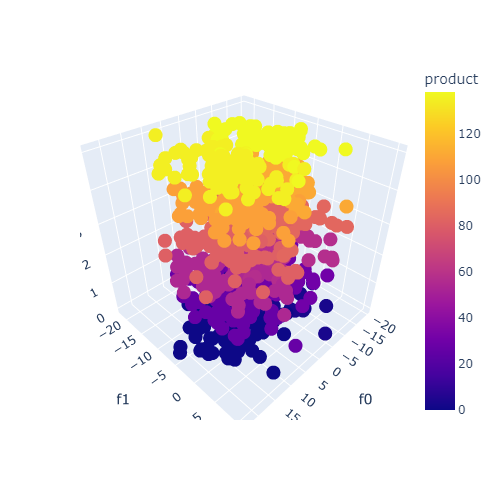

************************************************************


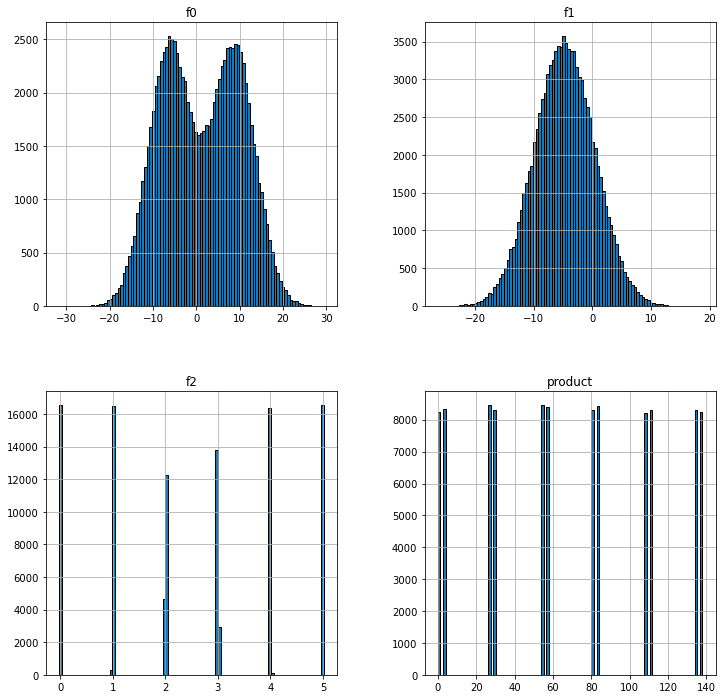

************************************************************


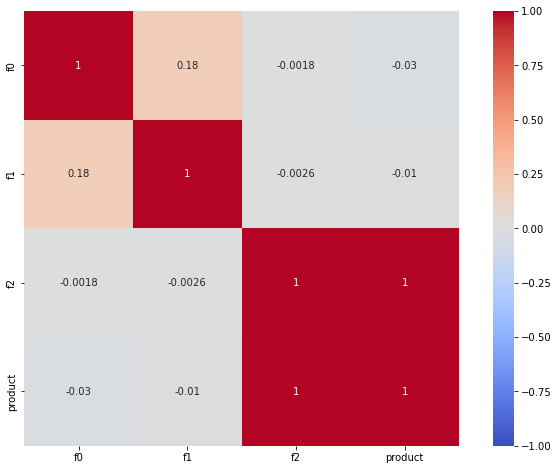

In [7]:
eda_info(geo_data_1)

Второй регион. Также как и в первом 5 признаков 100000 значений. 
Также есть несколько повоторов в столбце `id`
В столбце `f2` значения больше похожи на категориальные, и принимают значения близкие к целым числам 1, 2, 3, 4, 5

Также значения `f2` сильно коррелируют с целевым признаком `product`,

Похоже что признак в столбце `f2` показывает некое качество скважины разбивая скважины на группы, с высокой точностью предсказывая объем нефти содержащейся в скважине.

### Третий регион

In [8]:
profile = ProfileReport(geo_data_2, title='geo_data_2', progress_bar=False)
profile.to_file("geo_data_2.html")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
************************************************************


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


************************************************************
В датафрейме 0 полных дубликатов
************************************************************
Дубликаты по столбцу ID


,id,f0,f1,f2,product
0,xCHr8,1.633027,0.368135,-2.378367,6.120525
1,xCHr8,-0.847066,2.101796,5.597130,184.388641
2,VF7Jo,2.122656,-0.858275,5.746001,181.716817
3,VF7Jo,-0.883115,0.560537,0.723601,136.233420
4,KUPhW,0.231846,-1.698941,4.990775,11.716299
5,KUPhW,1.211150,3.176408,5.543540,132.831802
6,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
7,Vcm5J,2.587702,1.986875,2.482245,92.327572


************************************************************


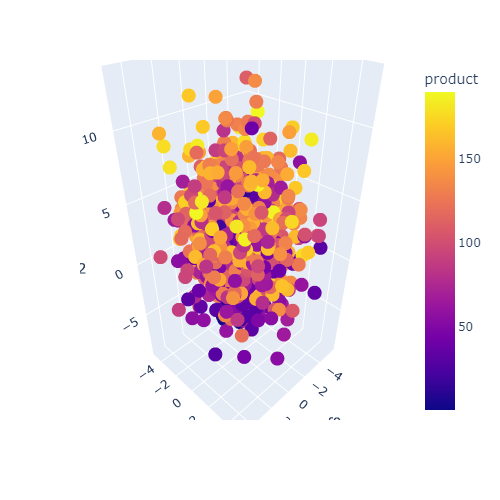

************************************************************


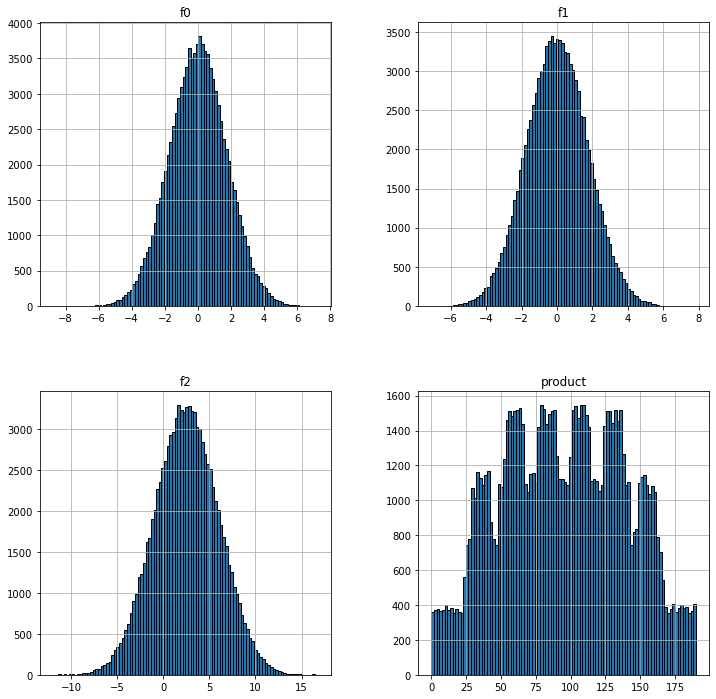

************************************************************


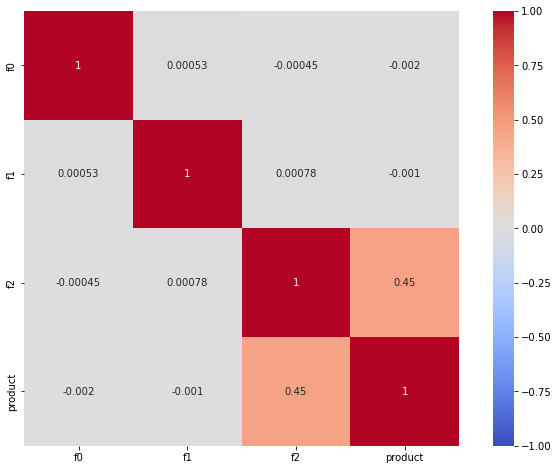

In [9]:
eda_info(geo_data_2)

Также как и в остальных данные содержат 5 признаков 100000 значений. 
Также есть несколько повоторов в столбце `id`. Сильных зависимостей между признаками нет

Данные формируют вытянутый эллипсоид вдоль оси `f2`. Наиболее высокие значения `product` при f2>0, по осям f1 и f0 чем дальше от 0 тем лучше. При этом часть очень низких значений `product` находится в центре эллипсоида вдоль оси f2

**Вывод:**
В первом разделе выполнили предварительную обработку данных:
* во всех трех регионах данные в целом подготовленные, минимальное количество выбросов
* пропуски отсутствуют
* есть совпадения по id, но их наиболее вероятная природа - работа генератора имен при шифровании
* между признаками сильная корреляция не обнаружена, во втором регионе признак `f2` сильно коррелирует с целевым признаком, учитывая это линейная регрессия будет основываться по большей части только на этом признаке, практически не принимая во внимание остальные
* учитывая форму распределения данных, похоже что данные нормализованы и уже подготовленны к обучению модели 


## Обучение и проверка модели

Разделим данные для обучения и проверки результата

In [10]:
def data_split(data, target, drop_f2=False): # drop_f2 для проверки второго региона без f2
    if drop_f2 == True:
        X, y = data.drop([target, 'id', 'f2'], axis=1), data[target]
    else:
        X, y = data.drop([target, 'id'], axis=1), data[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=42, 
        shuffle=True)
    
    print('Обучающая выборка:')
    print('Доля от общего размера:', round(len(y_train)/len(data), 2))
    print('Cтрок, столбцов:', X_train.shape)
    print('Среднее целевого признака:', round(y_train.mean(), 3))
    print('-'*30)


    print('Тестовая выборка:')
    print('Доля от общего размера:', round(len(y_test)/len(data), 2))
    print('Cтрок, столбцов:', X_test.shape)
    print('Среднее целевого признака:', round(y_test.mean(), 3))
    print('-'*30)

    return X_train, X_test, y_train, y_test

Выборка для региона №1

In [11]:
X_train_0, X_test_0, y_train_0, y_test_0 = data_split(geo_data_0, 'product')

Обучающая выборка:
Доля от общего размера: 0.75
Cтрок, столбцов: (75000, 3)
Среднее целевого признака: 92.558
------------------------------
Тестовая выборка:
Доля от общего размера: 0.25
Cтрок, столбцов: (25000, 3)
Среднее целевого признака: 92.326
------------------------------


Выборка для региона №2

In [12]:
X_train_1, X_test_1, y_train_1, y_test_1 = data_split(geo_data_1, 'product')

Обучающая выборка:
Доля от общего размера: 0.75
Cтрок, столбцов: (75000, 3)
Среднее целевого признака: 68.858
------------------------------
Тестовая выборка:
Доля от общего размера: 0.25
Cтрок, столбцов: (25000, 3)
Среднее целевого признака: 68.725
------------------------------


Если столбец f2 окажется не доступен до разработки скважины

In [13]:
X_train_1_1, X_test_1_1, y_train_1_1, y_test_1_1 = data_split(geo_data_1, 'product', drop_f2=True)

Обучающая выборка:
Доля от общего размера: 0.75
Cтрок, столбцов: (75000, 2)
Среднее целевого признака: 68.858
------------------------------
Тестовая выборка:
Доля от общего размера: 0.25
Cтрок, столбцов: (25000, 2)
Среднее целевого признака: 68.725
------------------------------


Выборка для региона №3

In [14]:
X_train_2, X_test_2, y_train_2, y_test_2 = data_split(geo_data_2, 'product')

Обучающая выборка:
Доля от общего размера: 0.75
Cтрок, столбцов: (75000, 3)
Среднее целевого признака: 94.95
------------------------------
Тестовая выборка:
Доля от общего размера: 0.25
Cтрок, столбцов: (25000, 3)
Среднее целевого признака: 95.151
------------------------------


Для выбранной по условию модели будем использовать простой pipeline без перебора параметров

In [15]:
def tube(X_train, X_test, y_train, y_test):
    pipe = Pipeline([('scl', StandardScaler()),
                     ('clf',LinearRegression())])

    pipe.fit(X_train, y_train)
    pred_0 = pipe.predict(X_test)
    pred_0_mean = pd.Series(pred_0).mean()
    
    print('RMSE модели для выбранного региона: %.4f' % (mean_squared_error(y_test, pred_0) ** 0.5))
    print('R2 модели для выбранного региона: %.4f' % r2_score(y_test, pred_0))
    print('Среднее предсказанное значение запасов региона: %.4f' % pred_0_mean)
    return pred_0

Регион №1

In [16]:
pred_0 = tube(X_train_0, X_test_0, y_train_0, y_test_0)

RMSE модели для выбранного региона: 37.7566
R2 модели для выбранного региона: 0.2728
Среднее предсказанное значение запасов региона: 92.3988


Регион №2

In [17]:
pred_1 = tube(X_train_1, X_test_1, y_train_1, y_test_1)

RMSE модели для выбранного региона: 0.8903
R2 модели для выбранного региона: 0.9996
Среднее предсказанное значение запасов региона: 68.7129


Регион №2 без f2

In [18]:
pred_1_1 = tube(X_train_1_1, X_test_1_1, y_train_1_1, y_test_1_1)

RMSE модели для выбранного региона: 45.9240
R2 модели для выбранного региона: 0.0009
Среднее предсказанное значение запасов региона: 68.8489


Регион №3

In [19]:
pred_2 = tube(X_train_2, X_test_2, y_train_2, y_test_2)

RMSE модели для выбранного региона: 40.1459
R2 модели для выбранного региона: 0.1963
Среднее предсказанное значение запасов региона: 94.7710


**Вывод:**
Лучший результат линейная регрессия показала себя на данных по второму региону, в котором  ранее выявлена сильная корреляция между `f2` и целевым признаком. Причем метрика R2 показывает идеальный результат, в остальных случаях качество предсказания очень низкое.
Линейная регрессия хорошо работает с линейными зависимостями, следовательно такую модель обнаружила только во данных для второго региона.

Также оказалось что все предсказание модели для региона №2 строилось по признаку f2, и без него получить предсказание с помощью линейной регрессии не получилось

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек,

In [20]:
OILWELL_TOTAL_COUNT = 500

из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [21]:
OILWELL_BEST_COUNT = 200

Бюджет на разработку скважин в регионе — 10 млрд рублей.

In [22]:
BUDGET_TOTAL = 10**10

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [23]:
PROFIT_1KBARREL = 450000

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.

In [24]:
PROBABILITY_OF_LOSS = 0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [25]:
BUDGET_FOR_ONE = BUDGET_TOTAL / OILWELL_BEST_COUNT
MIN_OIL_IN_WELL = BUDGET_FOR_ONE / PROFIT_1KBARREL
MIN_OIL_IN_REGION = MIN_OIL_IN_WELL * OILWELL_BEST_COUNT

In [26]:
print("Средний объем нефти для для скважины в регионе: %.2f" % MIN_OIL_IN_WELL)

Средний объем нефти для для скважины в регионе: 111.11


**Вывод:** 
По результатам расчетов для безубыточной добычи средний объем содержания нефти в скважине должен быть равен 111,11. По результатам наших расчетов во всех регионах среднее содержание нефти меньше чем необходимо. Следовательно выбрав скважину случайно, не учитывая другие параметры с большой вероятностью компания получит убыток.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли с лучших скважин в регионе

In [27]:
def profit_region(target, prediction):
    pred_series = pd.Series(prediction).sort_values(ascending=False)[:OILWELL_BEST_COUNT]
    target_sort = (target.reset_index(drop = True)[pred_series.index])
    sum_true = target_sort.sum()
    return ((sum_true * PROFIT_1KBARREL) - BUDGET_TOTAL).round(2)

И функцию расчета вероятности убытков, средней выручки, и доверительного интервала по заданным значениям

In [28]:
def bootstrap_confidence_intervals_loss(target, prediction):
    state = np.random.RandomState(42)
    values = []

    for i in range(1000):
        sort_series = pd.Series(prediction)
        value = sort_series.sample(n = OILWELL_TOTAL_COUNT, 
                                   replace=True, 
                                   random_state=state)
        values.append(profit_region(target, value))


    values = pd.Series(values)
    mean = values.mean()

    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    
    probability_of_loss = (values < 0).mean() * 100

    print("Вероятность убытков: %.2f" % probability_of_loss, '%')
    print("Средняя выручка: %.2f" % mean, 'rub')
    print("0.025-квантиль: %.2f" % lower, 'rub')
    print("0.975-квантиль: %.2f" % higher, 'rub')

Регион №1

In [29]:
bootstrap_confidence_intervals_loss(y_test_0, pred_0)

Вероятность убытков: 6.00 %
Средняя выручка: 399575478.05 rub
0.025-квантиль: -110467895.33 rub
0.975-квантиль: 897460327.71 rub


Регион №2

In [30]:
bootstrap_confidence_intervals_loss(y_test_1, pred_1)

Вероятность убытков: 1.50 %
Средняя выручка: 452048890.91 rub
0.025-квантиль: 61684479.65 rub
0.975-квантиль: 845340177.50 rub


Регион №3

In [31]:
bootstrap_confidence_intervals_loss(y_test_2, pred_2)

Вероятность убытков: 8.00 %
Средняя выручка: 375009902.92 rub
0.025-квантиль: -144766727.31 rub
0.975-квантиль: 888390403.53 rub


**Вывод:** В доверительный интервал по условию задачи с вероятностью убытков менее 2,5% попадает только регион номер 2. Даные для данного региона позволяют с высокой точностью спрогнозировать объем добычи с каждой скважины.


## Вывод

Проведено исследование данных с целью определения региона с возможностью получения максимальной прибыли и при этом с вероятностью получить убыток менее 2,5%

Данные получены подготовленные с минимальными выбросами и нормализованными.
В шифровании ID скважины обнаружены повторы возникшие из-за способа кодирования.
Во втором регионе обнаружена сильная корреляция между параметром `f2` и  `product`, необходимо проверить достоверность полученной информации.

При построении графиков в трех проекциях точечной диаграммы, можно заметить что распределения данных по форме сильно отличаются друг от друга . Это возможно из-за того что для каждого региона выбраны разные параметры зашифрованные под одними именами. Для корректного сравнения разных регионах желательно использовать одинаковые параметры если это возможно.

Для предсказания объемов добычи нами была использована модель линейная регрессия(по условию задачи) как демонстрирующая наиболее предсказуемые результаты. Но учитывая показанную точность для регионов №1 и №3, возможно стоит рассмотреть варианты использования других моделей машинного обучения которые справляются не только с линейными зависимостями.

Для безубыточной добычи в пределах бюджета средний запас нефти в одной скавжине должен составлять не менее 111,11.
Максимально близкое значение предсказанных запасов показал регион №3 94.7

Но по результатам оценки методом bootstrap лучший результат с учетом риска получения убытка менее 2,5% показал только регион №2.

На основании полученных результатов рекомендуется выбрать регион №2 (`geo_data_1`).